In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from engine import ValueTensor
from visuals import draw_dot
from optim import SGD
from model import MLP

In [3]:
def mse(y, y_pred):
    return ((y - y_pred) ** 2).mean()

In [4]:

def train():
    # Dummy data
    x_data = np.random.randn(100, 1)
    y_data = 2 * x_data + 3 + 0.1 * np.random.randn(100, 1)  # Add noise

    # Wrap in ValueTensors
    X = ValueTensor(x_data)
    Y = ValueTensor(y_data)

    # Model
    model = MLP([1, 10, 1], activation='relu')
    optimizer = SGD(model.parameters(), lr=0.05)

    # Training loop
    for epoch in range(1000):
        # Forward
        preds = model(X)
        loss = mse(preds, Y)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.data}")

    return loss

l = train()


Epoch 0: Loss = [[17.693]]
Epoch 100: Loss = [[0.036]]
Epoch 200: Loss = [[0.016]]
Epoch 300: Loss = [[0.012]]
Epoch 400: Loss = [[0.011]]
Epoch 500: Loss = [[0.01]]
Epoch 600: Loss = [[0.01]]
Epoch 700: Loss = [[0.01]]
Epoch 800: Loss = [[0.01]]
Epoch 900: Loss = [[0.01]]


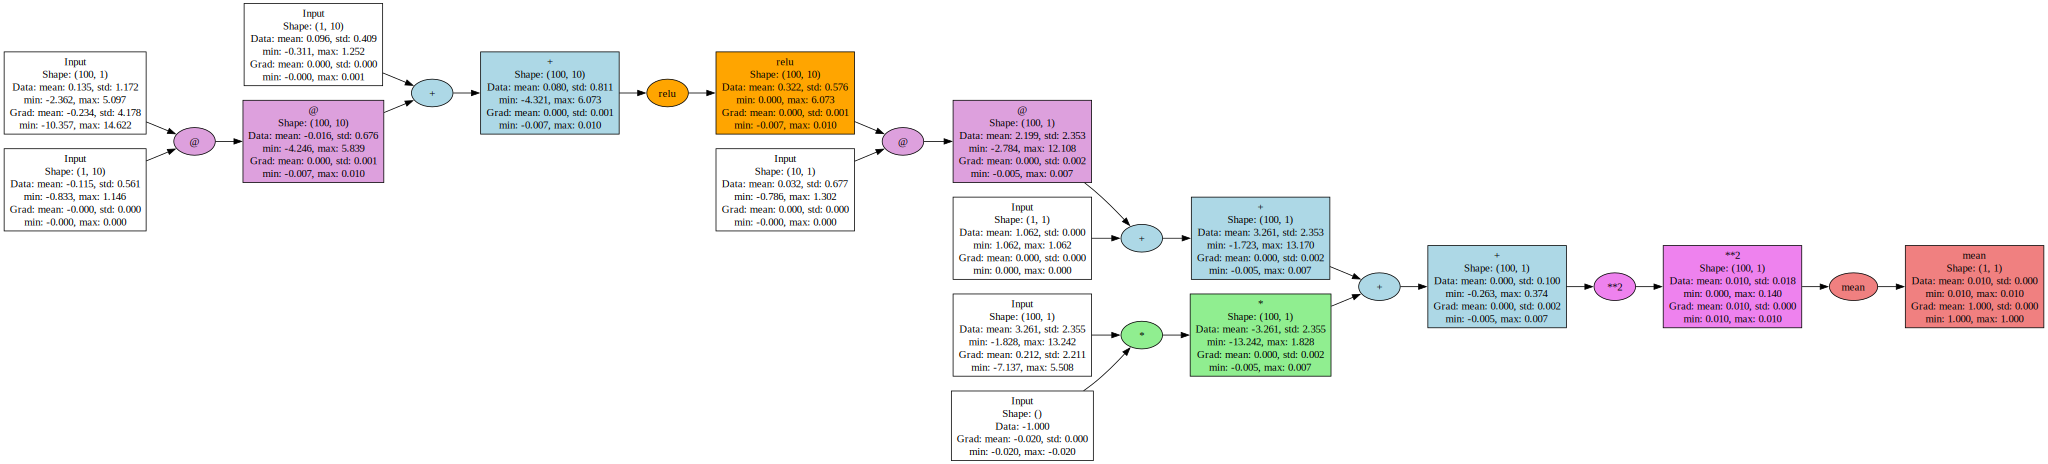

In [5]:
draw_dot(l)